<a href="https://colab.research.google.com/github/Anubhav3084/Deep-Learning/blob/main/RNNs/Stock_price_prediction_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

prices = pd.read_csv("https://raw.githubusercontent.com/LinkedInLearning/recurrent-neural-networks-2478142/main/Exercise%20Files/FB-stock-prices.csv")
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


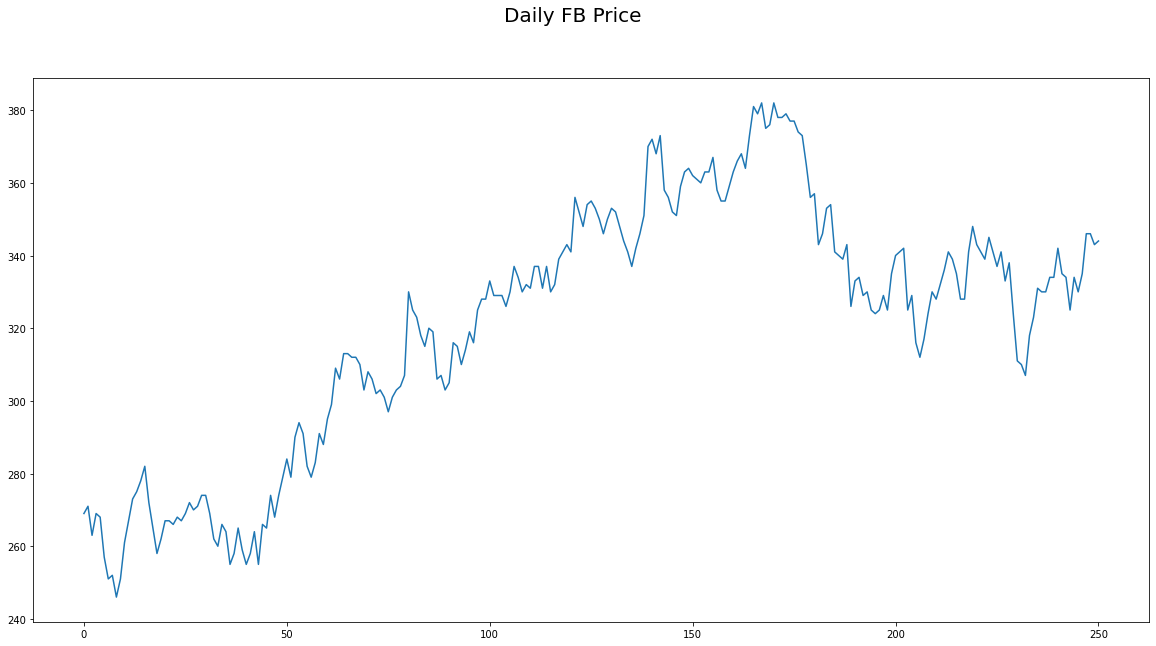

In [7]:
# plot the data to visualize the stock price

plt.figure(figsize=(20,10)).suptitle("Daily FB Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

##**Split Data**

---



In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices[["Price"]].values)

# split data into training and test sets
total_size = len(scaled_prices)

# test dataset size
test_size = 50

# training dataset size
train_size = total_size - test_size
print(train_size, test_size)

# for sequential training, split data sequentially and not randomly
training_prices = scaled_prices[0:train_size, :]
test_prices = scaled_prices[train_size:, :]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


##**Create Dataset for RNN**

In [10]:
# prepare RNN dataset
# Each data point (X) is linked to the previous data points of size=lookback
# The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []

    for i in range(len(data) - lookback - 1):
        # all points from this point, looking backwars upto lookback
        a = data[i:(i+lookback), 0]
        data_x.append(a)

        # the next point
        data_y.append(data[i+lookback, 0])
    return np.array(data_x), np.array(data_y)

# lookback for 25 previous days
lookback = 25

# create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices, lookback)

# reshape for use with RNN
train_req_x = np.reshape(train_req_x, (train_req_x.shape[0],1,train_req_x.shape[1]))

print("Shapes of X, Y", train_req_x.shape, train_req_y.shape)

Shapes of X, Y (175, 1, 25) (175,)


###**Build the RNN Model**

In [18]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import tensorflow as tf

tf.random.set_seed(3)

# create a Keras Model
price_model = Sequential()

# add a simple RNN layer with 32 nodes
price_model.add(SimpleRNN(32, input_shape=(1,lookback)))

# add a dense layer at the end for the output
price_model.add(Dense(1))

# compile with Adam Optimizer. Optimize for minimum mean swuare error
price_model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mse"]
)

# print model summary
price_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [19]:
# train the model
price_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
175/175 [==============================] - 2s 3ms/step - loss: 0.1876 - mse: 0.1876
Epoch 2/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0957 - mse: 0.0957
Epoch 3/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0631 - mse: 0.0631
Epoch 4/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0492 - mse: 0.0492
Epoch 5/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0443 - mse: 0.0443


##**Test the Model**

In [20]:
test_req_x, test_req_y = create_rnn_dataset(test_prices, lookback)

print(test_req_x.shape, test_req_y.shape)

test_req_x = np.reshape(test_req_x, (test_req_x.shape[0],1,test_req_x.shape[1]))

# evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

# predict on the test dataset
predict_on_test = price_model.predict(test_req_x)

# inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 25) (24,)
1/1 [==============================] - 1s 545ms/step - loss: 0.0803 - mse: 0.0803


##**Visualize the results**

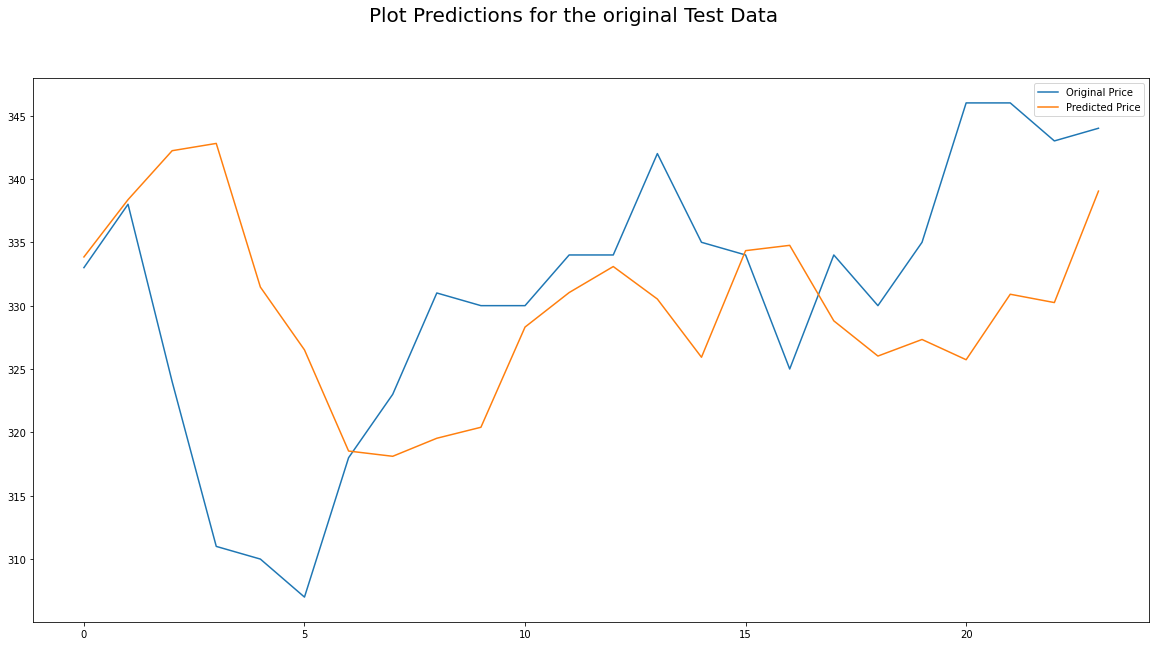

In [21]:
# extract original test values that map to the same dates on the predicted test calues
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for the original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

##**Predictions**

In [22]:
#Previous prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

#Scale
scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))
#Reshape
model_input = np.reshape(scaled_prices, 
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

#predictions
prediction = price_model.predict(model_input)

#scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

The predicted Stock price is : 335.2395
